# INSTACART MARKET  BASKET ANALYSIS

Kaggle 커널에 올라온 자료로 공부한 내용을 정리한 자료이다.<br>
해당 자료에서는 Light GBM을 적용하는 과정에 집중을 하도록하고, 각 데이터에 대한 탐색은 EDA자료를 참고하도록 한다.

<b> 스크립트 작성자 : Paul-Antoine Nguyen  </b>  <br>
<b> 해설 및 추가 설명 : Jaehoon Kim </b> <br><br>
이 스크립트는 고객이 주문한 모든 물품들을 고려한다고 한다.<br>
모델의 학습은 "train" 데이터의 재주문 확률을 계산하여 진행하였다. <br>
<br>
결과 제출에 대하여는 일정 확률 수치를 넘긴 건에 대하여만 재주문한다고 보았다.

#### 출처 : <a href = "https://www.kaggle.com/paulantoine/light-gbm-benchmark-0-3692/code"> 해당 페이지로 이동 </a>

## 사용한 라이브러리

<b>1. numpy</b><br>
<b>2. pandas</b><br>
<b>3. lightgbm</b> : LGBM은 트리 기반의 알고리즘을 사용하는 gradient boosting 프레임워크이다.<br>
<p>
### LGBM이 다른 트리 기반의 알고리즘과 어떻게 다를까?
LGBM은 트리를 수직적(Leaf-wise)으로 성장시킨다. 보통 알고리즘들은 수평적(Level-wise)로 성장시킨다. LGBM은 성장할 때 델타 손실이 최대가 되는 잎을 고른다. 이 Leaf-wise 알고리즘은 Level-wise 알고리즘보다 손실(loss)를 더 줄일 수 있다. 아래는 Leaf-wise와 Level-wise를 비교한 그림이다.<br>
<img src="img_set/leaf_wise.png" width="500" height="500">
<img src="img_set/level_wise.png" width="500" height="500">
<p>
### LGBM이 이토록 인기를 끄는 이유는 무엇일까?
데이터의 크기가 날이 갈수록 커짐에 따라 데이터 과학에 쓰이는 전통적인 알고리즘으로는 빠른 결과를 가지기가 힘들어졌다. LGBM은 앞에 "Light"라고 어두에서 언급되고 있다. 왜냐하면 <b>빠른 속도</b>를 가지고 있기 때문이다. LGBM은 또한 <b>대용량의 데이터를 핸들링</b>할 수 있으며 코드를 실행하는데에 <b>비교적 적은 메모리를 차지</b>한다.<br>LGBM이 인기있는 또 다른 이유는 이 알고리즘이 <b>결과의 정확도(accuracy)</b>에 집중하기 때문이다. LGBM은 <b>그래픽 카드를 이용한 학습(GPU Learning)</b>을 지원하며 위와 같은 이유들로 인하여 데이터 과학자들로부터 많이 사용되고 있다.<br>

<p>
### LGBM은 모든 곳에 쓰일 수 있나요?
<b>아닙니다.</b> LGBM이 작은 데이터셋에 이용되는 것은 권장되지 않습니다. 왜냐하면 LGBM은 오버피팅에 민감하기 때문에 작은 데이터에서는 오버핏이 쉽게 일어나기 때문입니다. 일단 LGBM을 어느 정도의 크기의 데이터에서 사용해야한다는 공식적인 룰은 없지만 내 경험에 의하면 <b>적어도 10,000 행 이상의 데이터</b>에서만 사용하는 것을 권장한다.<br>

<br>
\*\* LGBM에 대한 전반적인 설명은 <a href = "https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc" > 관련 페이지</a>를 참고하였음.
<br>
\*\* Leaf-wise와 Level-wise에 대한 설명은 <a href= "https://datascience.stackexchange.com/questions/26699/decision-trees-leaf-wise-best-first-and-level-wise-tree-traverse" > 다음 페이지</a>를 참고할 것.

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
IDIR = 'data/' # 경로 설정

## 인스타카트 데이터 불러오기
### 왜 dtype로 피처마다의 데이터 타입을 지정하였을까?
파이썬에 입력되는 데이터는 기본적으로 int64, float64 ... 등 64비트 입니다.<br>
따라서 실제로 쓰는 자리 수는 두 자리라 하더라도 64비트가 허용하는 자리수 만큼 메모리를 차지하고 있게 됩니다. 즉, 메모리 낭비가 일어나며 데이터셋이 큰 경우에는 이 낭비되는 양이 더욱 커지게 됩니다. 따라서 적절한 데이터 타입으로 변환시켜주는 것이 필요하게 됩니다.<br>
<img src="img_set/01_dtype.png" width="500" height="500"><br><br>


### read_csv\(\)내에 있는 usecols 인자는 무엇에 쓰이는가요?
pandas.read_csv\(\) 내에 인자로 쓰이는 usecols는 필요한 칼럼만 가져오고 나머지는 버리도록하는 기능을 합니다. 


In [2]:
print('loading prior')
priors = pd.read_csv(IDIR + 'order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading train')
train = pd.read_csv(IDIR + 'order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading orders')
orders = pd.read_csv(IDIR + 'orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

print('loading products')
products = pd.read_csv(IDIR + 'products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32, #이 스크립트에서는 order_id를 제외하였다.
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'aisle_id', 'department_id'])

print('priors {}: {}'.format(priors.shape, ', '.join(priors.columns)))
print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))
print('train {}: {}'.format(train.shape, ', '.join(train.columns)))


loading prior
loading train
loading orders
loading products
priors (32434489, 4): order_id, product_id, add_to_cart_order, reordered
orders (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
train (1384617, 4): order_id, product_id, add_to_cart_order, reordered


## priors 데이터 조작하기 \( 제품 피처 계산하기 \) 
이 부분은 priors 데이터셋을 정리하여 product 데이터셋에 합치는 과정이다.<br>
<p>
#### prods 데이터셋의 피처 설명
<b>orders</b> : priors에서 product_id의 개수를 센 값이다. 얼마나 많이 판매된 상품인지 알 수 있다.<br>
<b>reorders</b> : priors의 product_id 별로 reordered 데이터를 통합한 뒤 이를 모두 더한다. 재구매인 경우 1 아닌 경우 0이므로 이 각 제품마다의 값들을 더한다면 재주문된 횟수를 알 수 있다.<br>
<b>reorder_rate</b> : 계산된 prods의 reorders 값을 orders 값으로 나눈 데이터.<br>
<br><br>
product_id를 기준으로해서 products 데이터셋과 새로만든 prods 데이터셋을 합친다.<br>
그리고 업데이트된 products 데이터셋의 인덱스 값을 product_id 칼럼으로 지정한다. <br>
<br>마지막에는 필요가 없어진 prods 데이터셋을 삭제한다.

<img src="img_set/02_groupby.png" width="600" height="600"> <br><br><br>
### size() 함수는 무엇인가요?
groupby\(\).size\(\)로 이용되며, groupby구문으로 생성된 데이터그룹의 데이터 개수를 구하는 함수이다.<br>
다만, count\(\)의 경우에는 NaN 값을 제외하는 반면 size\(\)의 경우에는 <b>NaN 값까지 개수에 포함</b>을 한다.<br>
** 예시와 자세한 내용은 <a href = "https://stackoverflow.com/questions/33346591/what-is-the-difference-between-size-and-count-in-pandas">관련 페이지</a>를 참고하도록 한다.

In [3]:
print('computing product f')
prods = pd.DataFrame()
prods['orders'] = priors.groupby(priors.product_id).size().astype(np.int32)
prods['reorders'] = priors['reordered'].groupby(priors.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)
del prods

computing product f


<b>아래의 코드는 orders 데이터셋을 prior 셋에 합치도록 진행한다.</b><br>
<img src="img_set/03_join_result.png" width="700" height="700">

In [4]:
print('add order info to priors')
orders.set_index('order_id', inplace=True, drop=False)
priors = priors.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)


add order info to priors


## 유저 피처 계산하기
이 부분은 orders 데이터셋을 정리하여 prior 데이터셋에 합치는 과정이다.

#### orders 데이터셋의 피처 설명 <br>
order_id : 주문번호(장바구니 번호)<br>
user_id : 고객번호<br>
eval_set : 어느 데이터 세트에 포함되는지 (prior? train?)<br>
order_number : 몇 번째 주문을 한 것인지(몇 번째로 주문한 장바구니인지)<br>
order_dow : dow는 day of week로 어떤 요일에 주문했는지 알 수 있다.<br>
order_hour_of_day : 몇 시에 주문했는지를 알 수 있다.<br>
days_since_prior_order : 같은 주문을 몇 일 전에 했었는지 알 수 있다.<br>

orders의 user_id를 그룹으로 묶은 뒤 days_since_prior_order의 평균을 구한다. (그 다음 float32로 데이터 타입을 변경해준다) <br>
orders의 user_Id 각각이 몇 번 주문을 했는지 size()함수를 이용해서 구한다.<br>
위 각각의 결과를 'average_days_between_orders'와 'nb_orders'라는 이름의 칼럼으로서 usr 데이터프레임에 삽입한다.<br>
<img src="img_set/04_usr.png" width="350" height="350"> <br>
<br>

#### priors 데이터셋의 피처 설명 <br>
order_id : 주문번호(장바구니 번호)<br>
product_id : 제품 번호<br>
add_to_cart_order : 장바구니에 집어넣은 순서<br>
reordered : 재주문 여부(0 ==> 재주문 X :::::  1 ==> 재주문 O)<br>
user_id : 고객 번호<br>
eval_set : 어느 데이터 세트에 포함되는지 (prior? train?)<br>
order_number : 몇 번째 주문을 한 것인지(몇 번째로 주문한 장바구니인지)<br>
order_dow : dow는 day of week로 어떤 요일에 주문했는지 알 수 있다.<br>
order_hour_of_day : 몇 시에 주문했는지를 알 수 있다.<br>
days_since_prior_order : 같은 주문을 몇 일 전에 했었는지 알 수 있다.<br>

priors의 각 user_id가 몇 개의 제품을 구매 했었는지 size()함수를 이용해서 구한다.<br>
set을 사용해서 각 user_id가 구매했던 제품 번호의 UNIQUE 값을 구한다. (set 자료형은 중복되는 데이터가 없도록하기 때문)<br>
그리고 그렇게 구한 제품번호의 UNIQUE 값이 각 user_id 별로 몇 개가 있는지 구한다.<br>
위 각각의 결과를 'total_items', 'all_products', 'total_distinct_items'라는 이름의 칼럼으로서 users 데이터프레임에 삽입한다.<br>
<img src="img_set/05_users.png" width="700" height="700"> <br>
<br>


새로 생성한 두 데이터프레임을 join한다. users에 usr을 조인한 결과는 다음과 같다.<br>
<img src="img_set/06_join.png" width="700" height="700"> <br>
<br>
마지막에는 필요가 없어진 usr 데이터프레임을 삭제한다. (이미 users 데이터프레임에 합쳤기 때문!)<br>
그리고 users 데이터프레임에 각 user_id의 \[총 구매 제품 개수\]를 \[총 구매 횟수\]로 나누어서 <b>한 번의 구매당 평균 몇 개의 제품을 구입</b>했는지에 대한 칼럼을 추가한다. 

In [5]:
### user features
print('computing user f')
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

users = pd.DataFrame()
users['total_items'] = priors.groupby('user_id').size().astype(np.int16)
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)

users = users.join(usr)
del usr
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32)
print('user f', users.shape)

computing user f
user f (206209, 6)


## [유저 X 제품] 피처 생성하기
\[유저X제품\]을 하기 위해서 product_id와 user_id를 하나로 합친 새로운 id를 생성한다.<br><br>
예시 )<br>
product_id : 123456<br>
user_id : 9999999<br>
====> user_product : 99999999123456 

In [6]:
### userXproduct features

print('compute userXproduct f - this is long...')
priors['user_product'] = priors.product_id + priors.user_id * 100000

compute userXproduct f - this is long...


#### PANDAS에서 itertuples는 어떤 쓰임을 가질까?<br>

데이터프레임에 itertuples()를 사용할 경우 각 행의 데이터를 튜플 자료형으로 반환한다.<br>
사용 예시는 다음과 같다.<br>
<img src="img_set/07_example.png" width="700" height="700"> <br>
( 출처 : https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.itertuples.html )
<br><br>
z에는 priors의 단일 user_product 데이터가 들어간다.<br>
따라서 딕셔너리d에 user_product가 없는 경우에는 새로 데이터를 추가한다.<br>
처음 데이터를 추가할 때 (1, (row.order_number, row.order_id), row.add_to_cart_order )에서 1은 업데이트가 이루어진 횟수를 의미한다.<br>
기존의 데이터가 딕셔너리에 있는 경우에는,<br> <b>#1</b> 업데이트 횟수를 1 추가하고,<br> <b>#2</b> 가장 최신의 주문순서 및 해당 장바구니 번호로 업데이트,<br> <b>#3</b> 장바구니에 추가한 순서를 기존의 값에 더한다.<br>
**딕셔너리d에는 각 유저의 구입한 제품 별 정보가 들어간다. <=== <b>user_product</b> !!

In [7]:
d= dict()
for row in priors.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1,
                (row.order_number, row.order_id),
                row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1,
                max(d[z][1], (row.order_number, row.order_id)),
                d[z][2] + row.add_to_cart_order)

결과로 나온 딕셔너리를 PANDAS의 userXproduct라는 데이터프레임으로 변환한다.<br>
각각의 칼럼의 의미는 다음과 같다.<br>
nb_orders : 해당 제품을 몇 번 구매를 하였는가?<br>
last_order_id : 해당 제품을 마지막으로 구매한 주문번호는 무엇인가?<br>
sum_pos_in_cart : 장바구니에 집어 넣은 순서 값에 대한 총 합<br>


In [8]:
print('to dataframe (less memory)')
userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d
userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1]).astype(np.int32)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
print('user X product f', len(userXproduct))

del priors

to dataframe (less memory)
user X product f 13293564


## Train / Test 준비

In [13]:
### train / test orders ###
print('split orders : train, test')
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

split orders : train, test


In [11]:
test_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,,
2774568,2774568,3,test,13,5,15,11.0
329954,329954,4,test,6,3,12,30.0
1528013,1528013,6,test,4,3,16,22.0
1376945,1376945,11,test,8,6,11,8.0
1356845,1356845,12,test,6,1,20,30.0


In [12]:
train_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,,
1187899,1187899,1,train,11,4,8,14.0
1492625,1492625,2,train,15,1,11,30.0
2196797,2196797,5,train,5,0,11,6.0
525192,525192,7,train,21,2,11,6.0
880375,880375,8,train,4,1,14,10.0


#### PANDAS에서 map()은 어떤 쓰임을 가질까?

map함수는 Series 타입에서<b>만</b> 사용해야 한다. (DataFrame 타입에서는 쓸 수 없다.)<br>
map함수는 설정된 함수 또는 딕셔너리를 가지고 Series의 값 하나하나에 접근하여 실행된다.<br><br>
<b># 01</b><br>
우선 설정된 함수를 적용하는 예시이다. 이는 apply()를 사용했을 때와 같은 진행을 하지만 <br>apply()는 DataFrame에서도 사용이 가능하다는 점을 기억해두자.<br>
<img src="img_set/09_map02.png" width="700" height="700">
<br>
이렇게 len() 함수를 적용할 경우에는 각 단어의 길이를 반환해준다.
<br><br>
<b># 02</b><br>
아래는 딕셔너리를 적용하는 예시이다.말 그대로 "map"(매핑)하는 기능인데, <br>딕셔너리의 key에 해당하는 데이터가 있다면 이를 key에 종속 된 value로 변환하는 역할을 한다. <br>
<img src="img_set/08_map01.png" width="700" height="700"> <br>
<br>
map함수 안에 정의된 딕셔너리의 key-value에 맞추어서 문자 데이터가 숫자로 변환된 것을 확인 할 수 있다.<br>
만일 딕셔너리 대신 Series자료형으로 넣을 경우에는 key는 Series 데이터의 인덱스 값이 되고 value는 컬럼 데이터가 된다.<br>
<br>
( 출처&참조 : https://www.youtube.com/watch?v=ektcpUz7Xb0 )<br>
\-------------------------------------------------------------------------------<br>
아래는 feature engineering에 관한 진행이므로 자세한 설명은 생략하도록 한다.<br>
처음에 주어진 train 데이터 세트를 LGBM에서 학습시킬 train 세트로 만드는 과정이다.




In [15]:
### build list of candidate products to reorder, with features ###

def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%10000 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in train.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    print('order related features')
    # df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    #df['UP_same_dow_as_last_order'] = df.UP_last_order_id.map(orders.order_dow) == \
    #                                              df.order_id.map(orders.order_dow)

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)

In [16]:
df_train, labels = features(train_orders, labels_given=True)

# 사용할 피처를 모아둔 리스트이다.
f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last'] # 'dow', 'UP_same_dow_as_last_order'


# LGBM에 사용하기 적합한 데이터세트로 변환한다.
# 이 부분은 반드시 거쳐야하는 과정이다!
# 카테고리 데이터가 있는 경우에는 이를 지정해줄 수 있다.
print('formating for lgb')
d_train = lgb.Dataset(df_train[f_to_use],
                      label=labels,
                      categorical_feature=['aisle_id', 'department_id'])  # 쓰지 않는 카테고리 데이터 --> 'order_hour_of_day', 'dow'
del df_train

build candidate list
order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
order row 80000
order row 90000
order row 100000
order row 110000
order row 120000
order row 130000
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              uint8
department_id                         uint8
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_or

In [18]:
# 설정할 파라미터
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}

# num_boost_round 파라미터에 들어갈 수치
# 100번까지 반복한다.
ROUNDS = 100

print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS)
# lgb.plot_importance(bst, figsize=(9,20))
del d_train

light GBM train :-)


C:\Users\lion5\Anaconda3\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


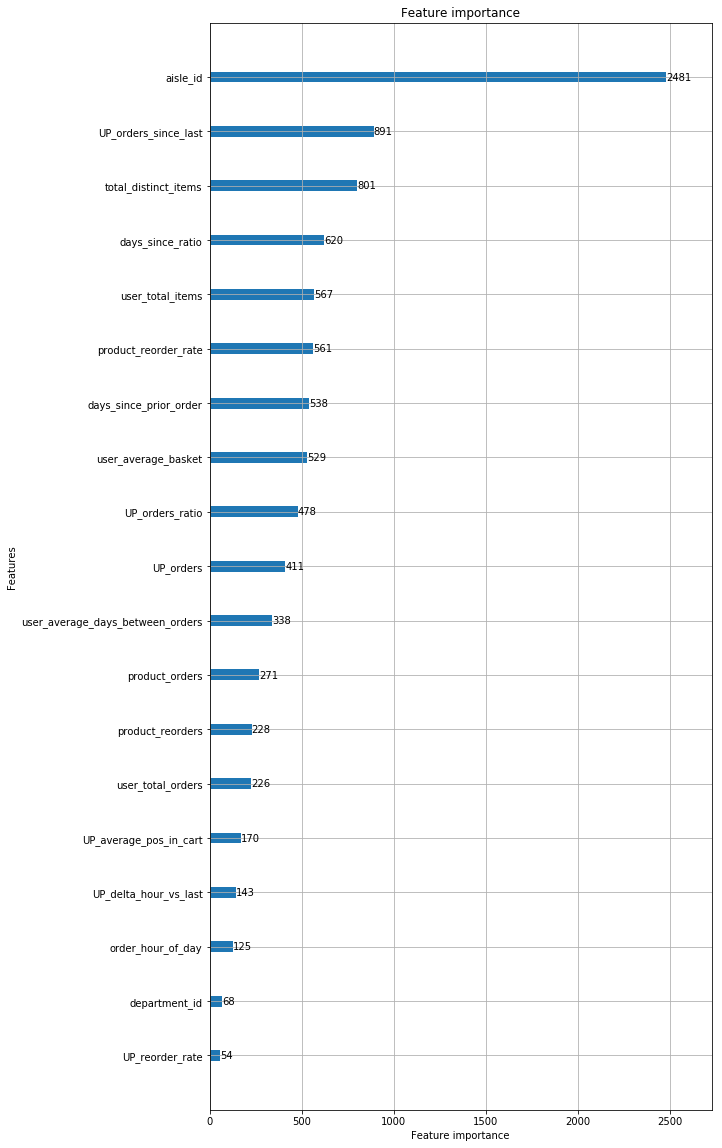

In [20]:
# 변수 별 중요도를 그래프로 보여준다.
import matplotlib.pyplot as plt
lgb.plot_importance(bst, figsize=(9,20))
plt.show()

In [21]:
### build candidates list for test ###

df_test, _ = features(test_orders)

print('light GBM predict')
preds = bst.predict(df_test[f_to_use])

df_test['pred'] = preds

# 여기서 TRESHOLD 부분은 스크립트를 작성한 사람이 그냥 추측한 값을 적은 것이다.
TRESHOLD = 0.22  # guess, should be tuned with crossval on a subset of train data

# LGBM은 이진 값에 대한 확률를 반환해주기 떄문에,
# 따로 한도를 정해서 0 또는 1로 분류를 해주어야한다. 

d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

# 이후에 아무런 재구매가 이루어지지 않는 경우도 고려를 한다.
for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

build candidate list
order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              uint8
department_id                         uint8
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_orders                             int16
UP_orders_ratio                     float32
UP_average_pos_in

In [22]:
sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub_instacart_01.csv', index=False)

In [23]:
a = pd.read_csv('sub_instacart_01.csv')
a.head()

,order_id,products
0,2774568,17668 21903 39190 47766 18599 43961 23650 24810
1,1528013,21903 38293
2,1376945,33572 28465 27959 44632 24799 34658 14947 8309...
3,1356845,11520 14992 7076 40377 28134 10863 13176
4,2161313,11266 196 10441 12427 37710 48142 14715 27839
